In [107]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import norm
from scipy.optimize import curve_fit

from astropy.io import fits
import astropy.units as u
from astropy.visualization import quantity_support

from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn import mixture

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [16,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [135]:
def kennicutt(x, A, n):
    return A * x**(n) #Kennicutt-Schimdt relation

In [72]:
#catalogues
mpajhu = '../catalogues/sdss_mpajhu_catalogue.fits'
passive = '../catalogues/sdss_portsmouth_passive_catalogue.fits'
starforming = '../catalogues/sdss_portsmouth_starforming_catalogue.fits'
HI = '../catalogues/AlfaAlfa_SDSS.fits'
mp_HI = '../catalogues/mp_HI.fits'
cross = '../catalogues/cross.fits' #matches of the 3 catalogues(mpajhu, HI, starforming)
manga = '../catalogues/SDSS17Pipe3D_v3_1_1.fits'
radius = '../catalogues/radius.fits'

catalogues = [mpajhu, passive, starforming, HI, mp_HI, cross, manga, radius]

In [60]:
#dictionaries
data = {
    
}

header = {
    
}

for cat in catalogues:
    hdul = fits.open(cat)
    data[cat] = hdul[1].data
    header[cat] = hdul[1].header
    hdul.close()

In [61]:
header[radius]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                 4439 / width of table in bytes                        
NAXIS2  =                  653 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                  555 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'name    '           / label for column 1                             
TFORM1  = '32A     '           / format for column 1                            
TTYPE2  = 'plate   '           / label for column 2                             
TFORM2  = 'K       '        

In [53]:
print(header[mpajhu])

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   72 / length of dimension 1                          NAXIS2  =              1472581 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    9 / number of table fields                         TTYPE1  = 'SDSS_SpecObjID'                                                      TFORM1  = 'K       '                                                            TTYPE2  = 'RA_degree'                                                           TFORM2  = 'D       '                                                            TTYPE3  = 'Dec_degree'                  

In [54]:
header[manga]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4307 / length of dimension 1                          
NAXIS2  =                10220 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                  536 / number of table fields                         
EXTNAME = 'GAL_PROPERTIES'                                                      
CHECKSUM= '2DXd5AVc2AVc2AVc'                                                    
DATASUM = '2013182490'                                                          
DATE-HDU= '2021-03-25T15:34:26'                                                 
STILVERS= '3.1     '        

In [36]:
header[HI]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                   44 / width of table in bytes                        
NAXIS2  =                31501 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                    8 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'AGC_1   '           / label for column 1                             
TFORM1  = 'J       '           / format for column 1                            
TTYPE2  = 'ObjID   '           / label for column 2                             
TFORM2  = 'K       '        

In [6]:
print(header[starforming])

XTENSION= 'BINTABLE'           / binary table extension                         BITPIX  =                    8 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                   64 / length of dimension 1                          NAXIS2  =               943001 / length of dimension 2                          PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TFIELDS =                    8 / number of table fields                         TTYPE1  = 'SDSS_SpecObjID'                                                      TFORM1  = 'K       '                                                            TTYPE2  = 'RA_degree'                                                           TFORM2  = 'D       '                                                            TTYPE3  = 'Dec_degree'                  

In [7]:
header[cross]

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional table                            
NAXIS1  =                  188 / width of table in bytes                        
NAXIS2  =                13537 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group                                 
TFIELDS =                   26 / number of columns                              
EXTNAME = 'Joined  '           / table name                                     
TTYPE1  = 'SDSS_SpecObjID_1'   / label for column 1                             
TFORM1  = 'K       '           / format for column 1                            
TTYPE2  = 'RA_degree_1'        / label for column 2                             
TFORM2  = 'D       '        

## initial plots

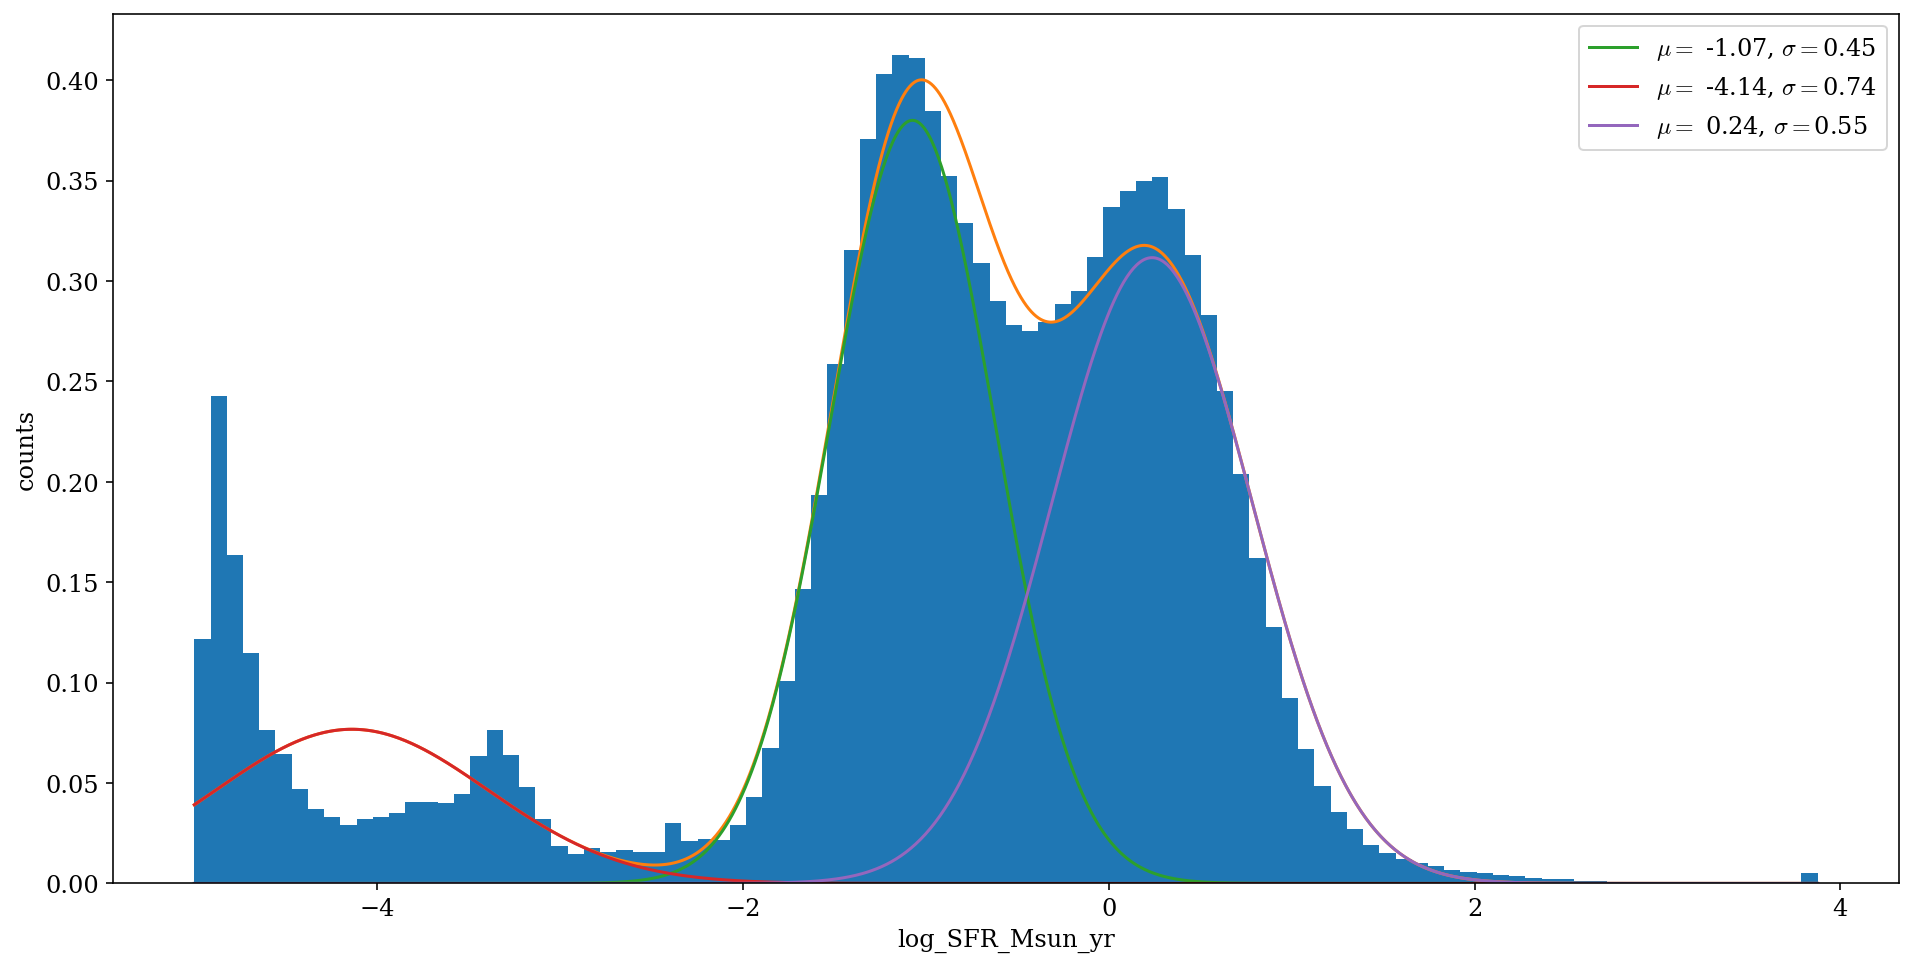

In [90]:
#histo SFR mpajhu 
key = 'log_SFR_Msun_yr'
sfr_mp = data[mpajhu].field(key)[data[mpajhu].field(key) > -9.99e3]
sfr_mp = sfr_mp[:, np.newaxis]

gm = mixture.GaussianMixture(n_components = 3, tol = 1e-3, n_init = 1)
gm_fitted = gm.fit(sfr_mp)
sfr_sorted = np.sort(sfr_mp, axis = 0)

plt.hist(sfr_mp[:,0], bins = 100, density = True)
plt.plot(sfr_sorted[:,0], np.exp(gm_fitted.score_samples(sfr_sorted)))

gaussians = [norm(mu, sigma) for mu, sigma in zip(gm_fitted.means_[:,0], np.sqrt(gm_fitted.covariances_[:,0]))]

x_grid = np.linspace(sfr_mp.min(), sfr_mp.max(), 1000)

[plt.plot(x_grid, weight * gaussian.pdf(x_grid), label = r'$\mu =$ %.2f, $\sigma = $%.2f' % (mu, sigma) )
 for weight, gaussian, mu, sigma in zip(gm_fitted.weights_, gaussians, gm_fitted.means_[:,0], np.sqrt(gm_fitted.covariances_[:,0]))]




plt.xlabel(key)
plt.ylabel('counts')
plt.legend()
plt.show()

In [34]:
print('the means are: ')
print(gm_fitted.means_)

print('\nthe covariances are: ')
print(gm_fitted.covariances_)

the means are: 
[[-0.24684256]
 [-4.09646345]
 [ 0.39543645]
 [-1.18784304]]

the covariances are: 
[[[0.20162605]]

 [[0.61568595]]

 [[0.29403189]]

 [[0.13193358]]]


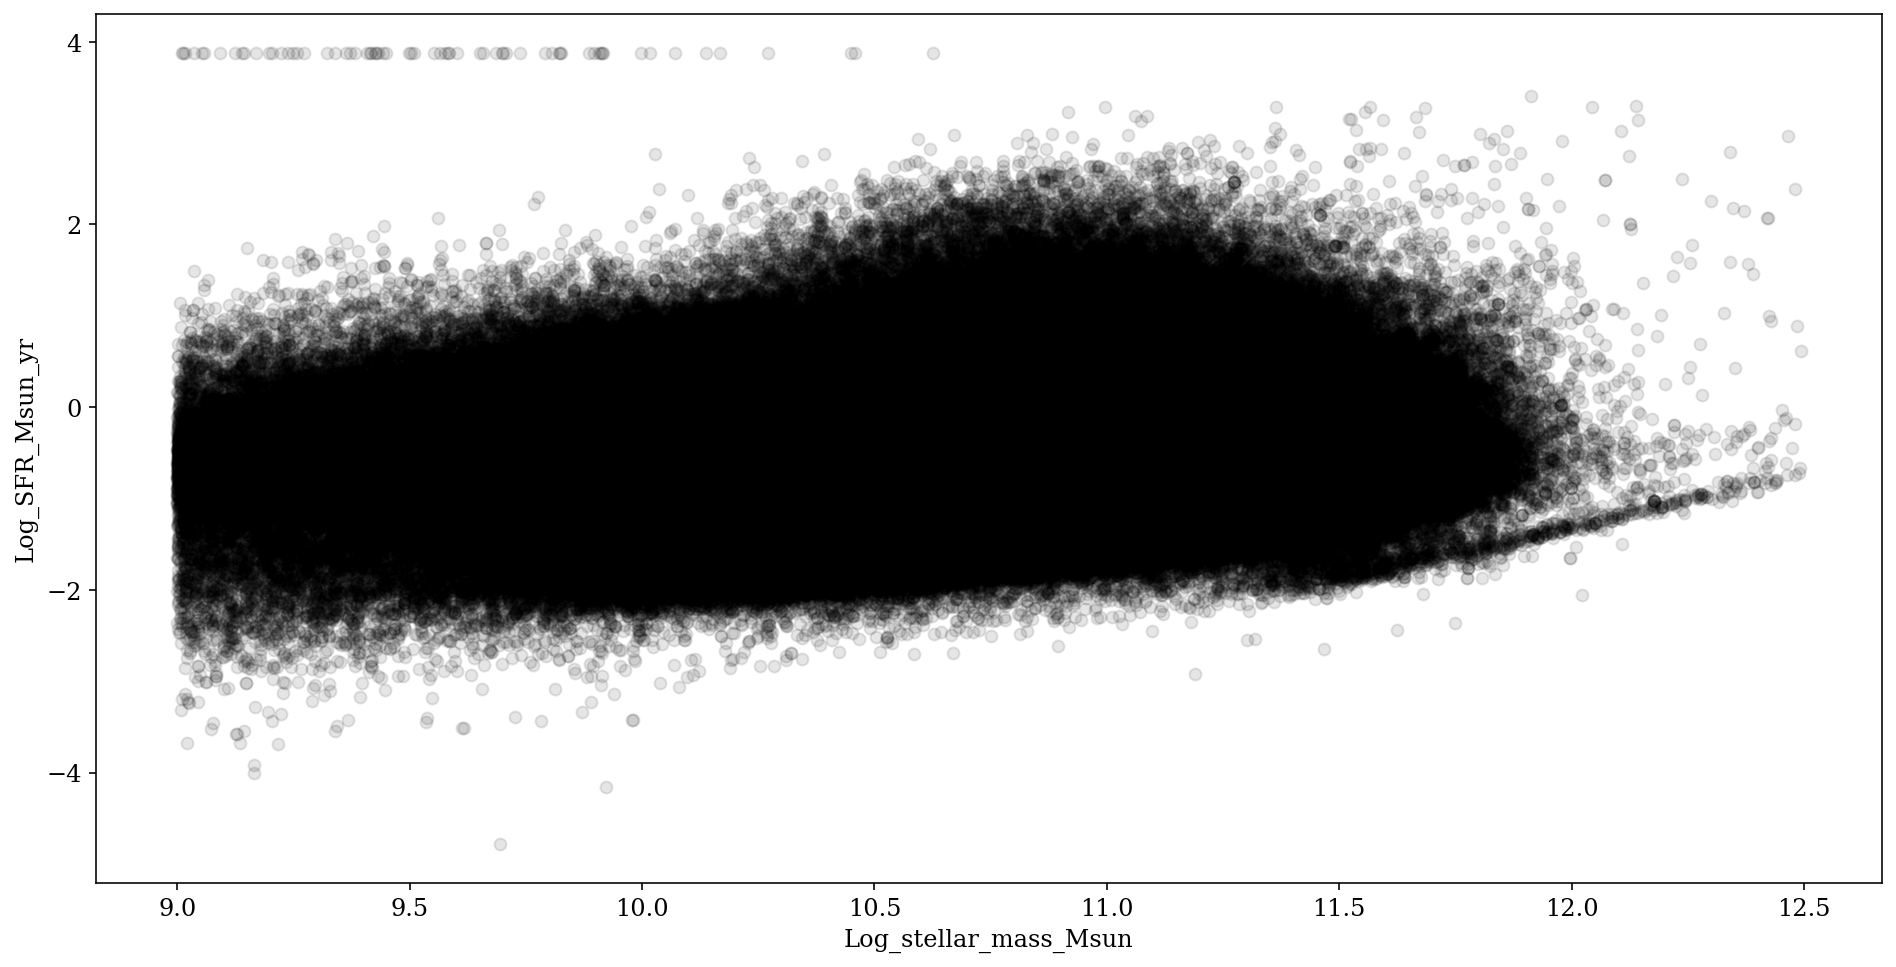

In [10]:
key_x = 'Log_stellar_mass_Msun'
key_y = 'Log_SFR_Msun_yr'

mask = (data[mpajhu].field(key_x) > -9.99e3) & (data[mpajhu].field(key_y) > -9.99e3) & (data[mpajhu].field('Log_stellar_mass_Msun') > 9)

x = data[mpajhu].field(key_x)[mask]
y = data[mpajhu].field(key_y)[mask]

plt.xlabel(key_x)
plt.ylabel(key_y)

plt.scatter(x, y, c='k', alpha = .1)
#plt.hist2d(x, y, bins = 100, cmap = 'binary')
#plt.colorbar()
plt.show()

### clustering

In [11]:
# K means with 2 clusters
n_clusters = 2
clf = KMeans(n_clusters = n_clusters)

X = np.array([x, y]).T #right shape for the fit module
clf.fit(X)
centers = clf.cluster_centers_ 
labels = clf.predict(X)

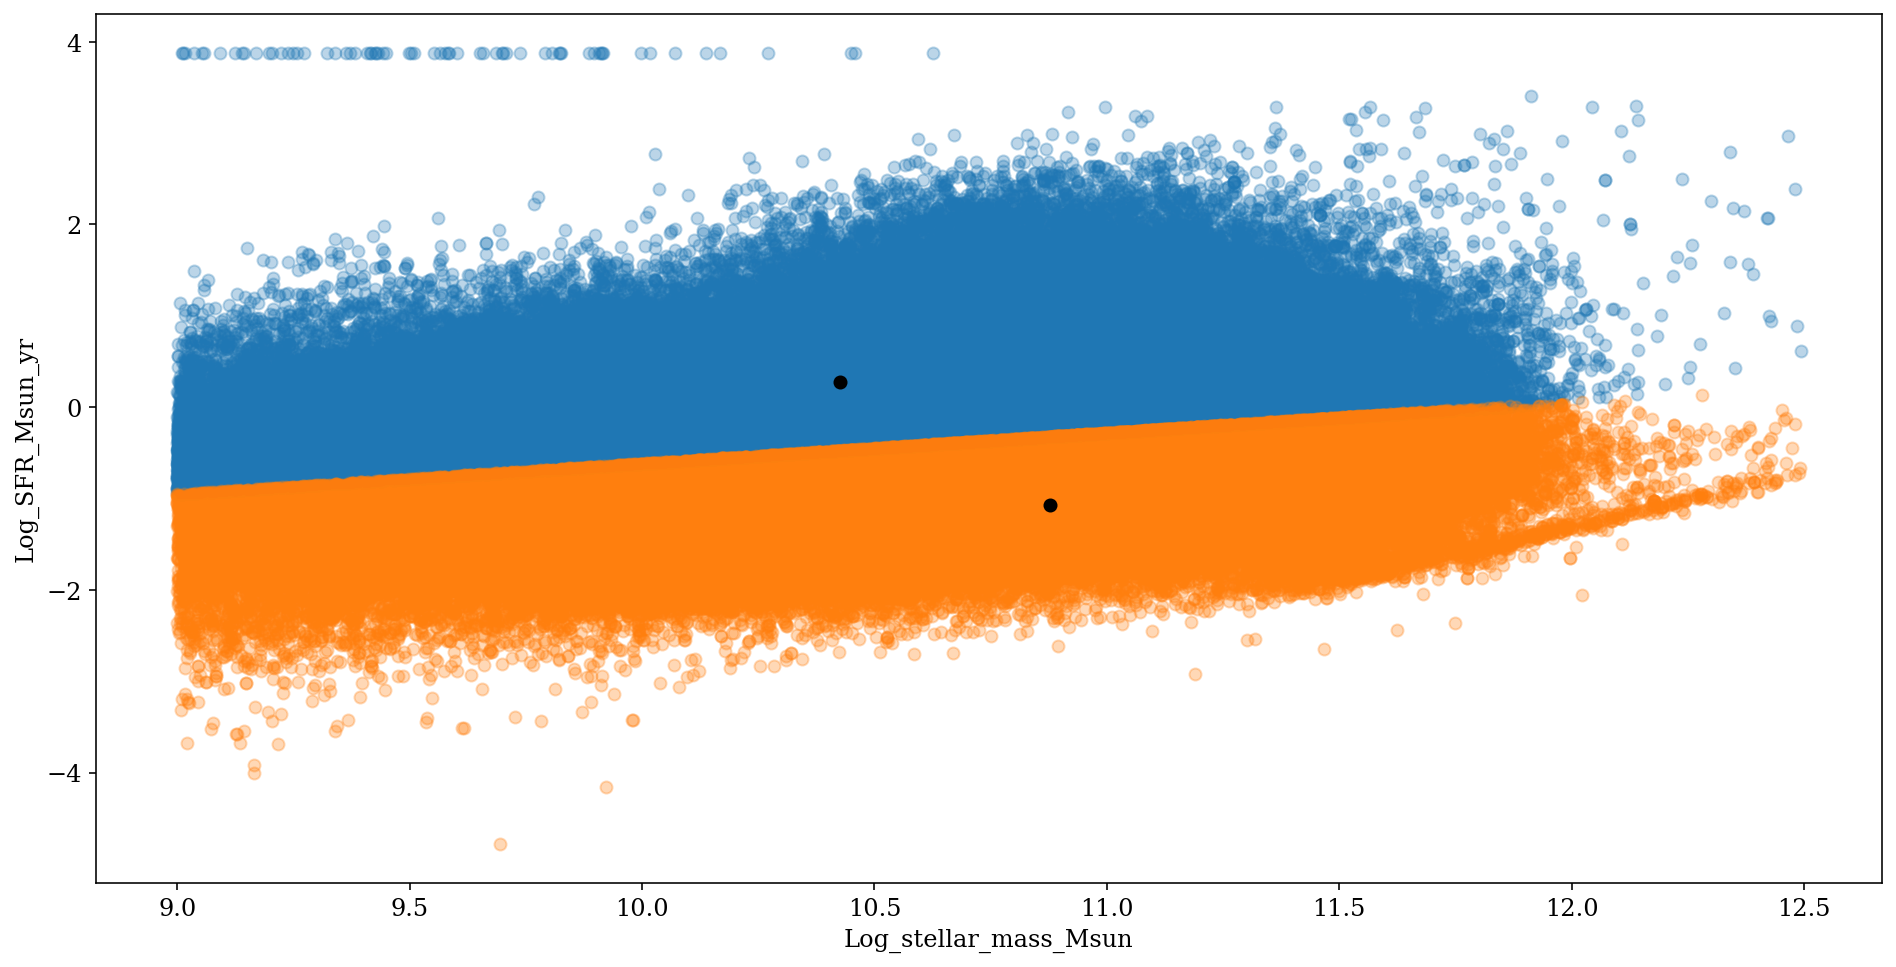

In [12]:
plt.figure()
for i in range(n_clusters):
    plt.scatter(X[labels == i, 0], X[labels == i, 1], alpha = 0.3)
plt.scatter(centers[:, 0], centers[:, 1], c='k')

plt.xlabel(key_x)
plt.ylabel(key_y)

#plt.loglog()
plt.show()

In [13]:
print(centers)

[[10.42498852  0.27813475]
 [10.87846724 -1.07437451]]


## gas consumption timescale (GCT)

In [14]:
mask = (data[cross].field('logMHI') > -9.99e3) & (data[cross].field('log_SFR_Msun_yr') > -9.99e3)

log_mass_HI = data[cross].field('logMHI')[mask]
log_sfr = data[cross].field('log_SFR_Msun_yr')[mask]
age = data[cross].field('Age_Gyr')[mask] * 1e9 #age in yr
gct = 10**(log_mass_HI - log_sfr) #gas consumption timescale in yr

In [15]:
mask = (data[mp_HI].field('logMHI') > -9.99e3) & (data[mp_HI].field('log_SFR_Msun_yr') > -9.99e3)

log_mass_HI_2 = data[mp_HI].field('logMHI')[mask]
log_sfr_2 = data[mp_HI].field('log_SFR_Msun_yr')[mask]

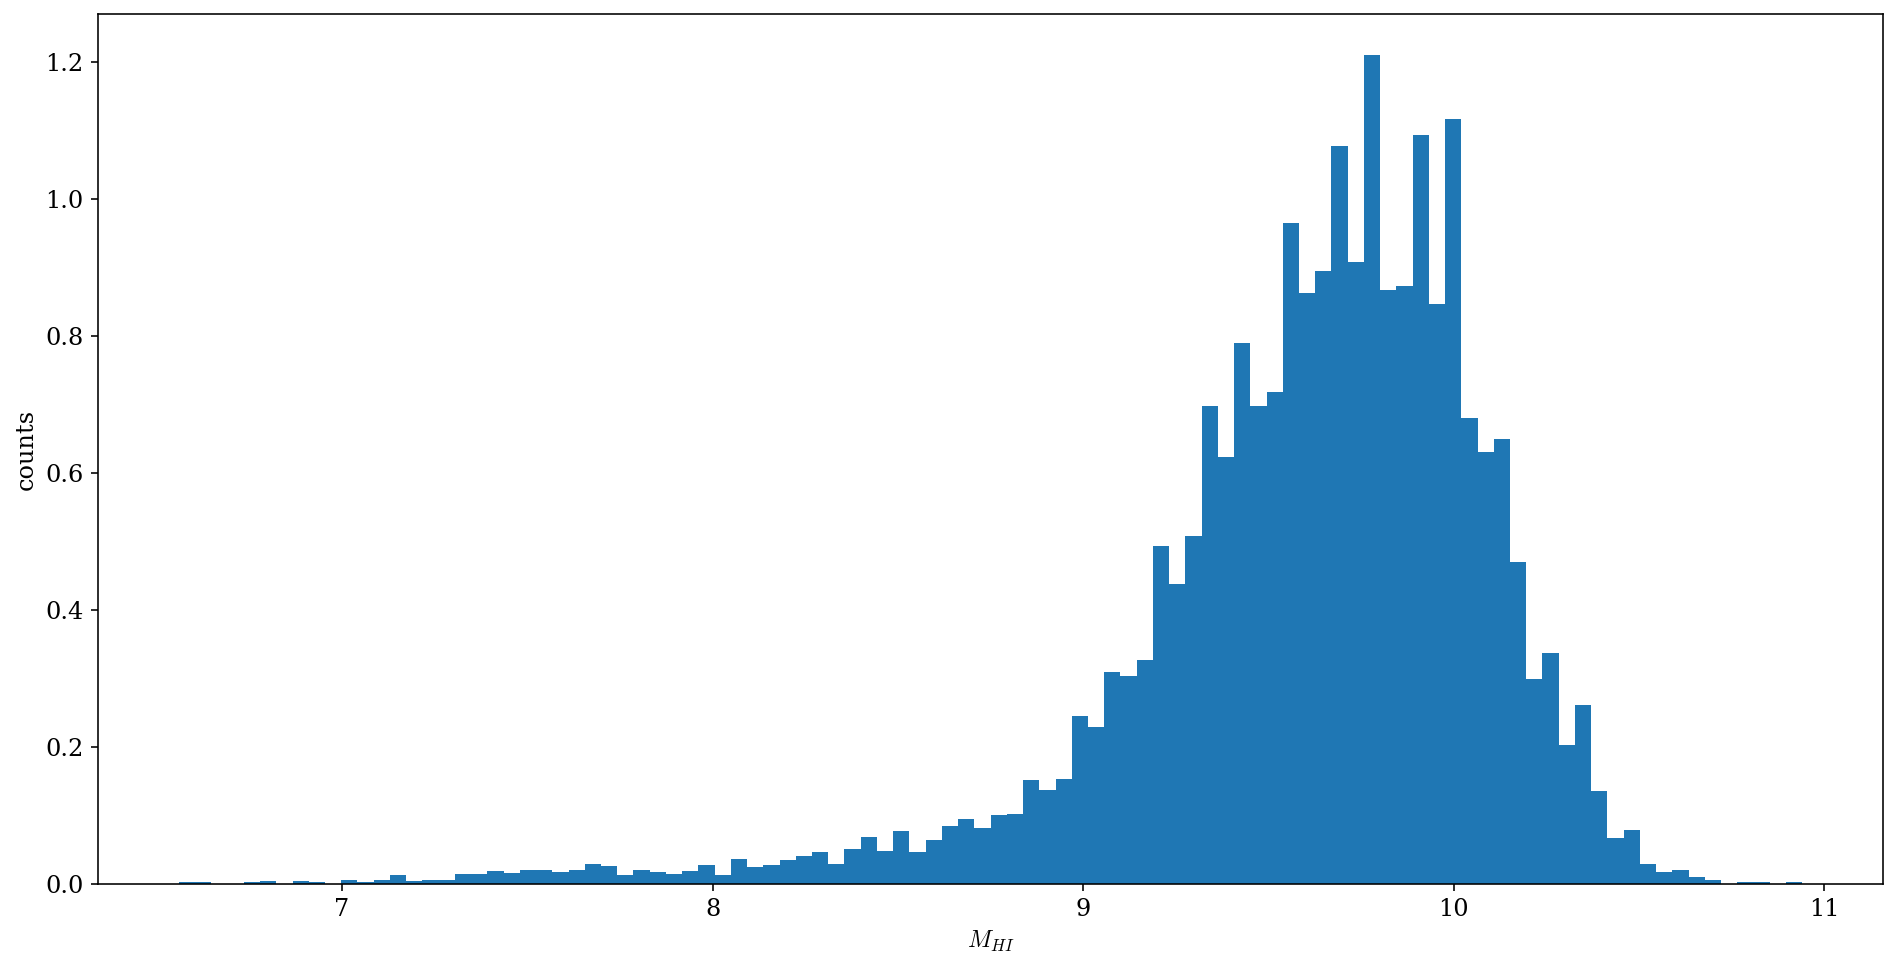

In [28]:
plt.hist(log_mass_HI, bins = 100, density = True)
plt.xlabel(r'$M_{HI}$')
plt.ylabel('counts')
plt.show()

In [39]:
centers

(2, 2)

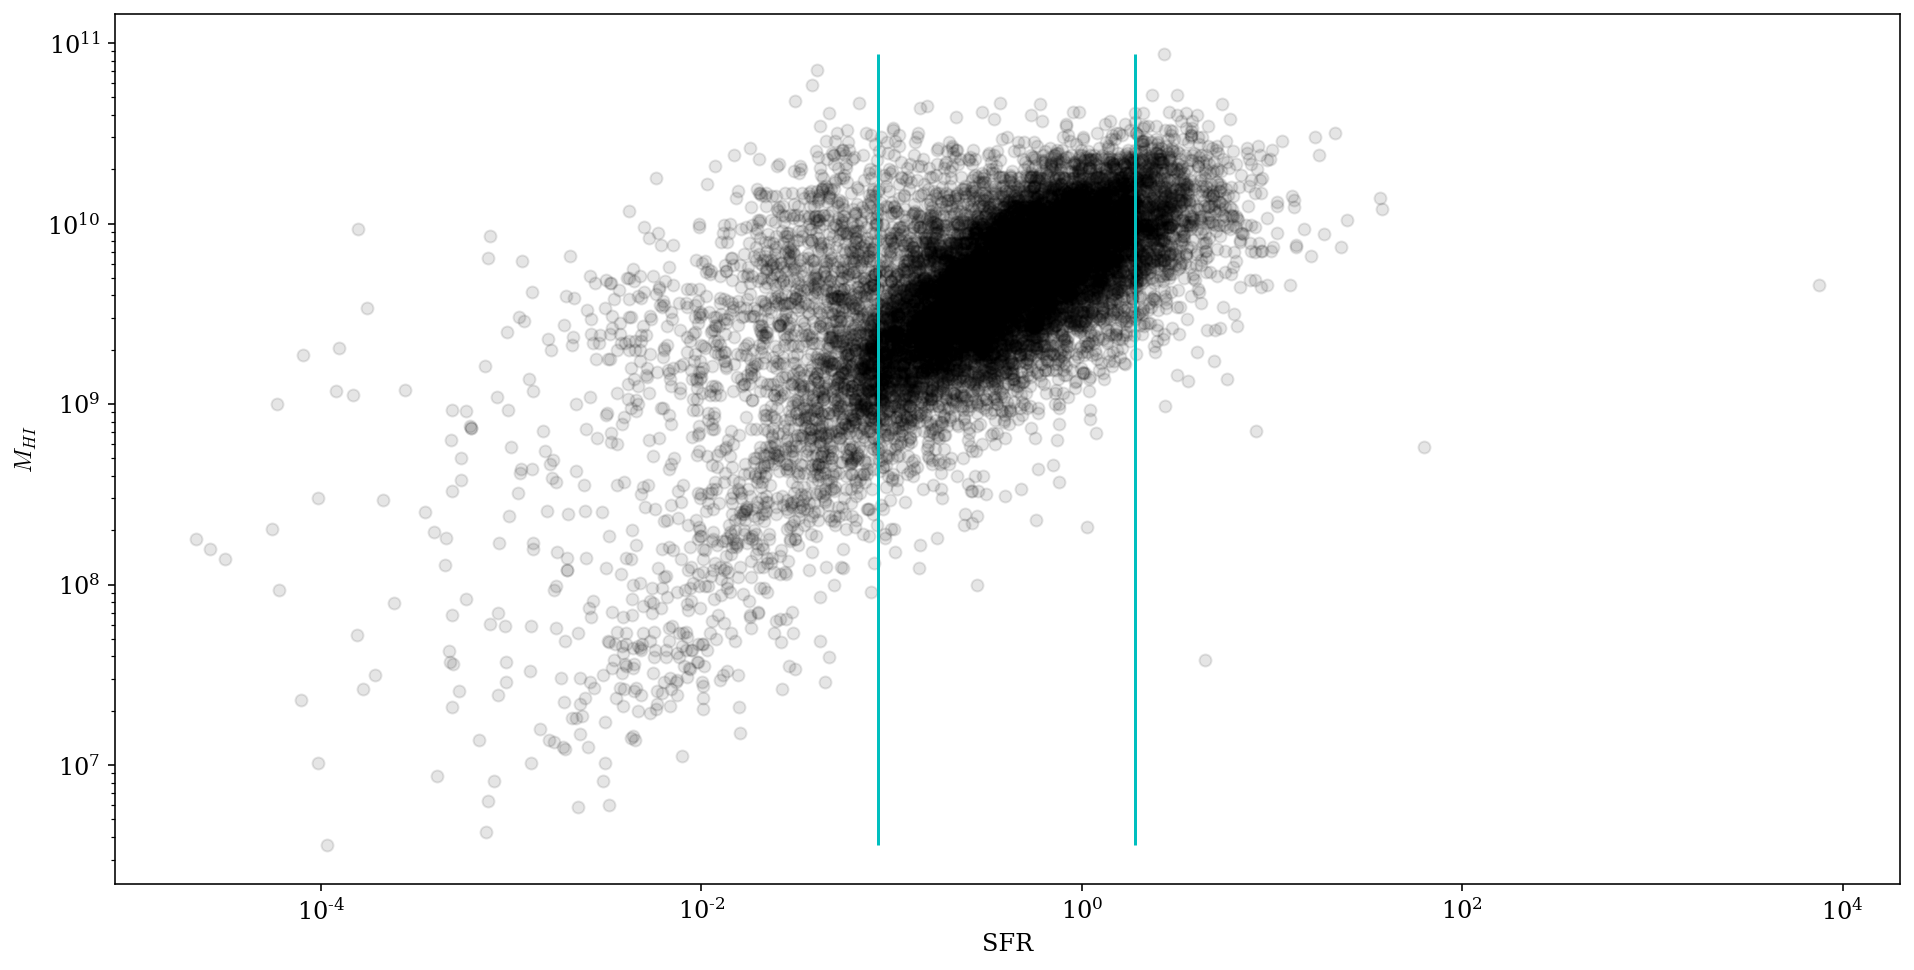

In [43]:
plt.scatter(10**log_sfr, 10**log_mass_HI, c='k', alpha = 0.1)
plt.vlines(10**centers[:,1], min(10**log_mass_HI), max(10**log_mass_HI), 'c')
plt.xlabel('SFR')
plt.ylabel(r'$M_{HI}$')
#plt.ylabel('logMHI')
plt.loglog()
#plt.title('timescales')
plt.show()

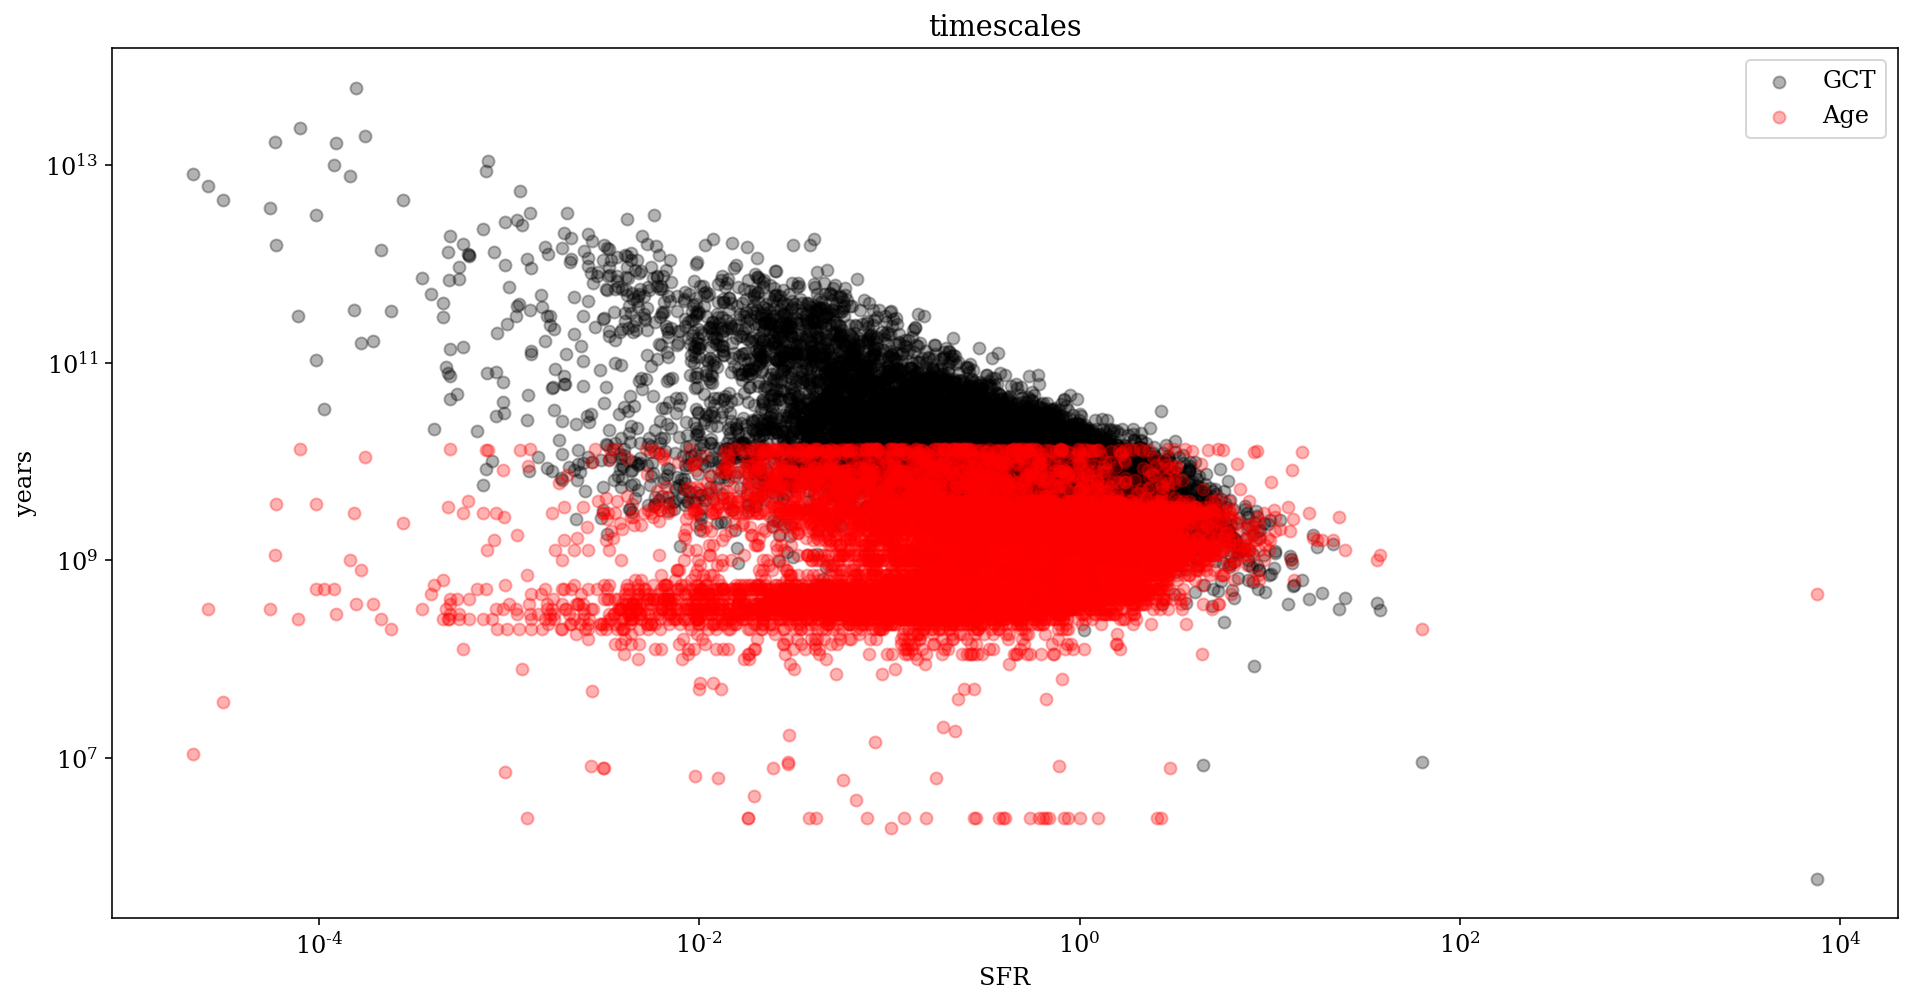

In [22]:
plt.scatter(10**log_sfr, gct, c='k', alpha = 0.3, label = 'GCT')
plt.scatter(10**log_sfr, age, c='r', alpha = 0.3, label = 'Age')
# plt.scatter(log_sfr_2, log_mass_HI_2, c='b', alpha = 0.1)
plt.xlabel('SFR')
plt.ylabel('years')
#plt.ylabel('logMHI')
plt.loglog()
plt.legend()
plt.title('timescales')

## HI density

In [141]:
mask = (data[radius].field('logMHI') > -9.99e3) & (data[radius].field('log_SFR_Msun_yr') > -9.99e3) & (data[radius].field('Re_kpc') > -9.99e3)

log_mass_HI = data[radius].field('logMHI')[mask]
log_sfr = data[radius].field('log_SFR_Msun_yr')[mask]
Re = data[radius].field('Re_kpc')[mask]

rho_HI = 10**log_mass_HI / Re**2

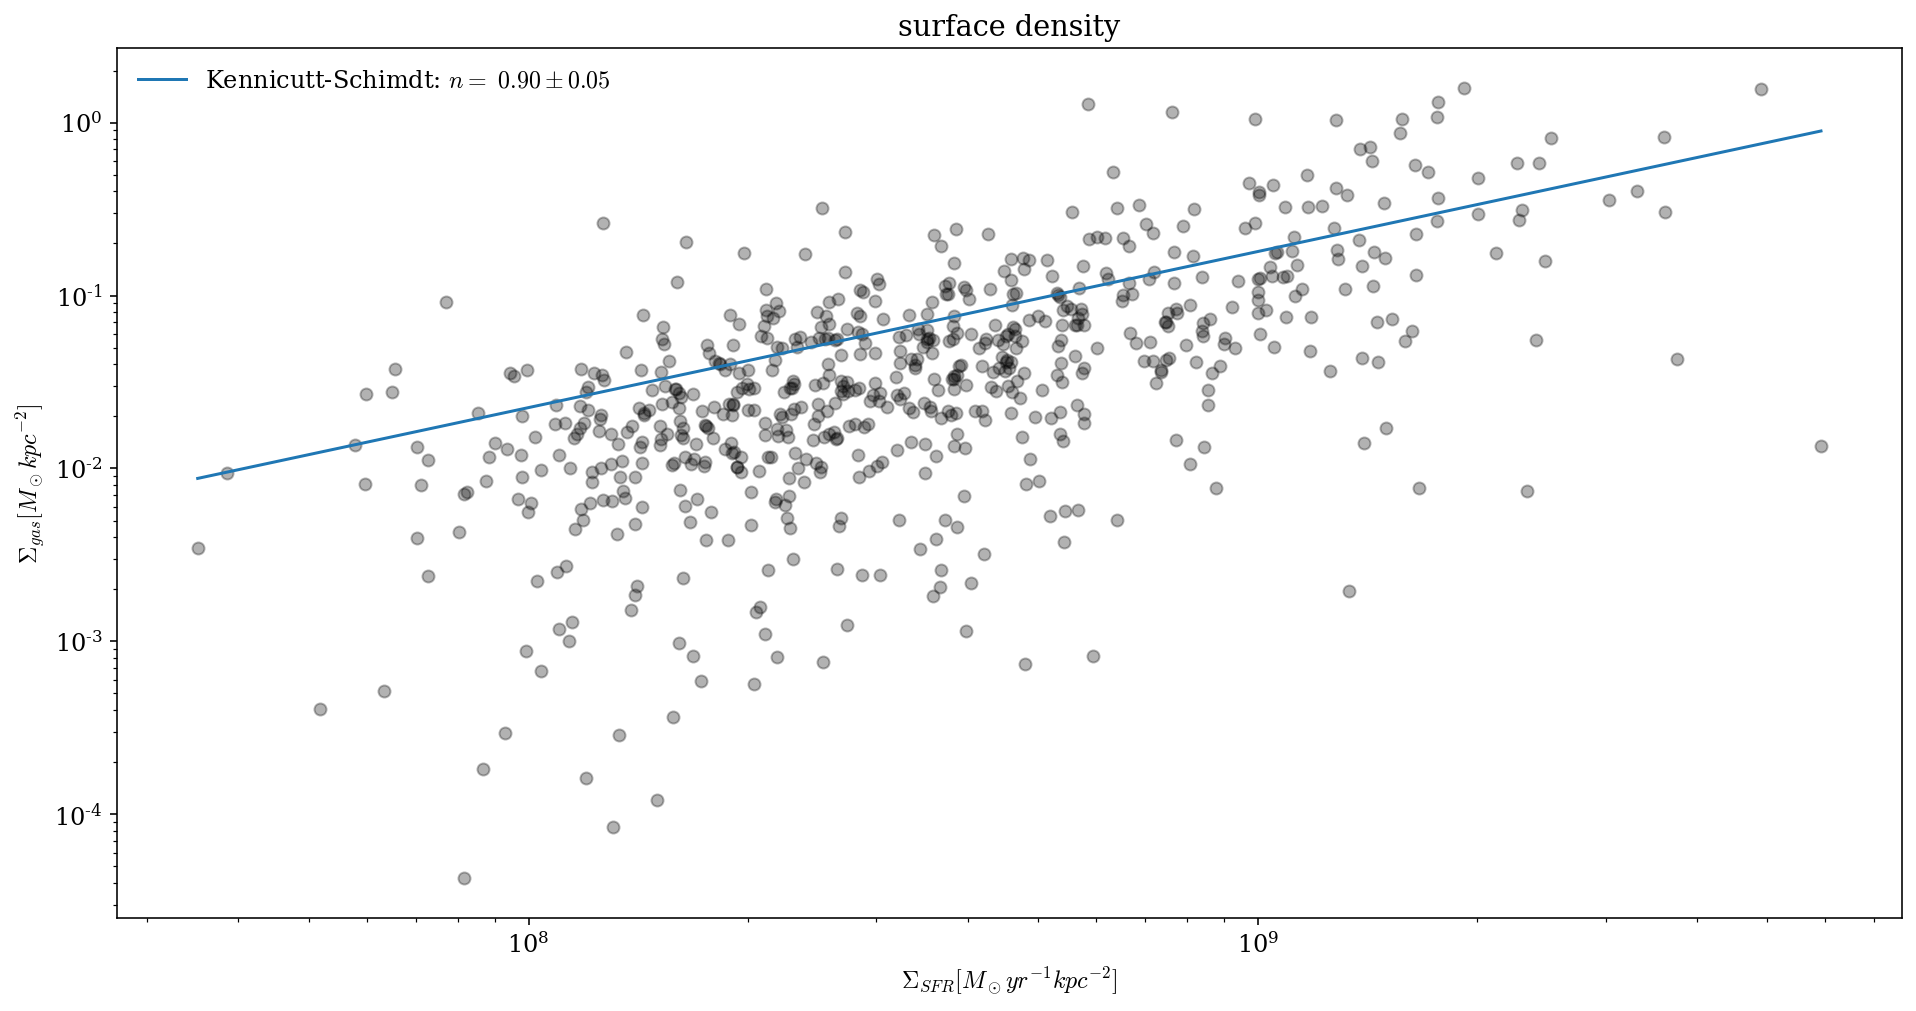

In [143]:
p0 = [1, 1]
best_p_0, cov_0 = curve_fit(kennicutt, rho_HI, 10**log_sfr / Re**2, p0 = p0)

grid = np.linspace(rho_HI.min(), rho_HI.max(), 1000)

plt.scatter(rho_HI, 10**log_sfr / Re**2, c='k', alpha = 0.3)
plt.plot(grid, kennicutt(grid, *np.abs(best_p_0)), label = 'Kennicutt-Schimdt: $n = $ $%.2f \pm %.2f $' % (best_p_0[1], np.sqrt(cov_0[1,1])))

plt.xlabel(r'$\Sigma_{SFR}[M_\odot yr^{-1} kpc^{-2}]$')
plt.ylabel(r'$\Sigma_{gas}[M_\odot kpc^{-2}]$')
plt.loglog()
plt.legend(frameon = False)
plt.title('surface density')
plt.show()

**HP: high SFR == high gas mass and density?**

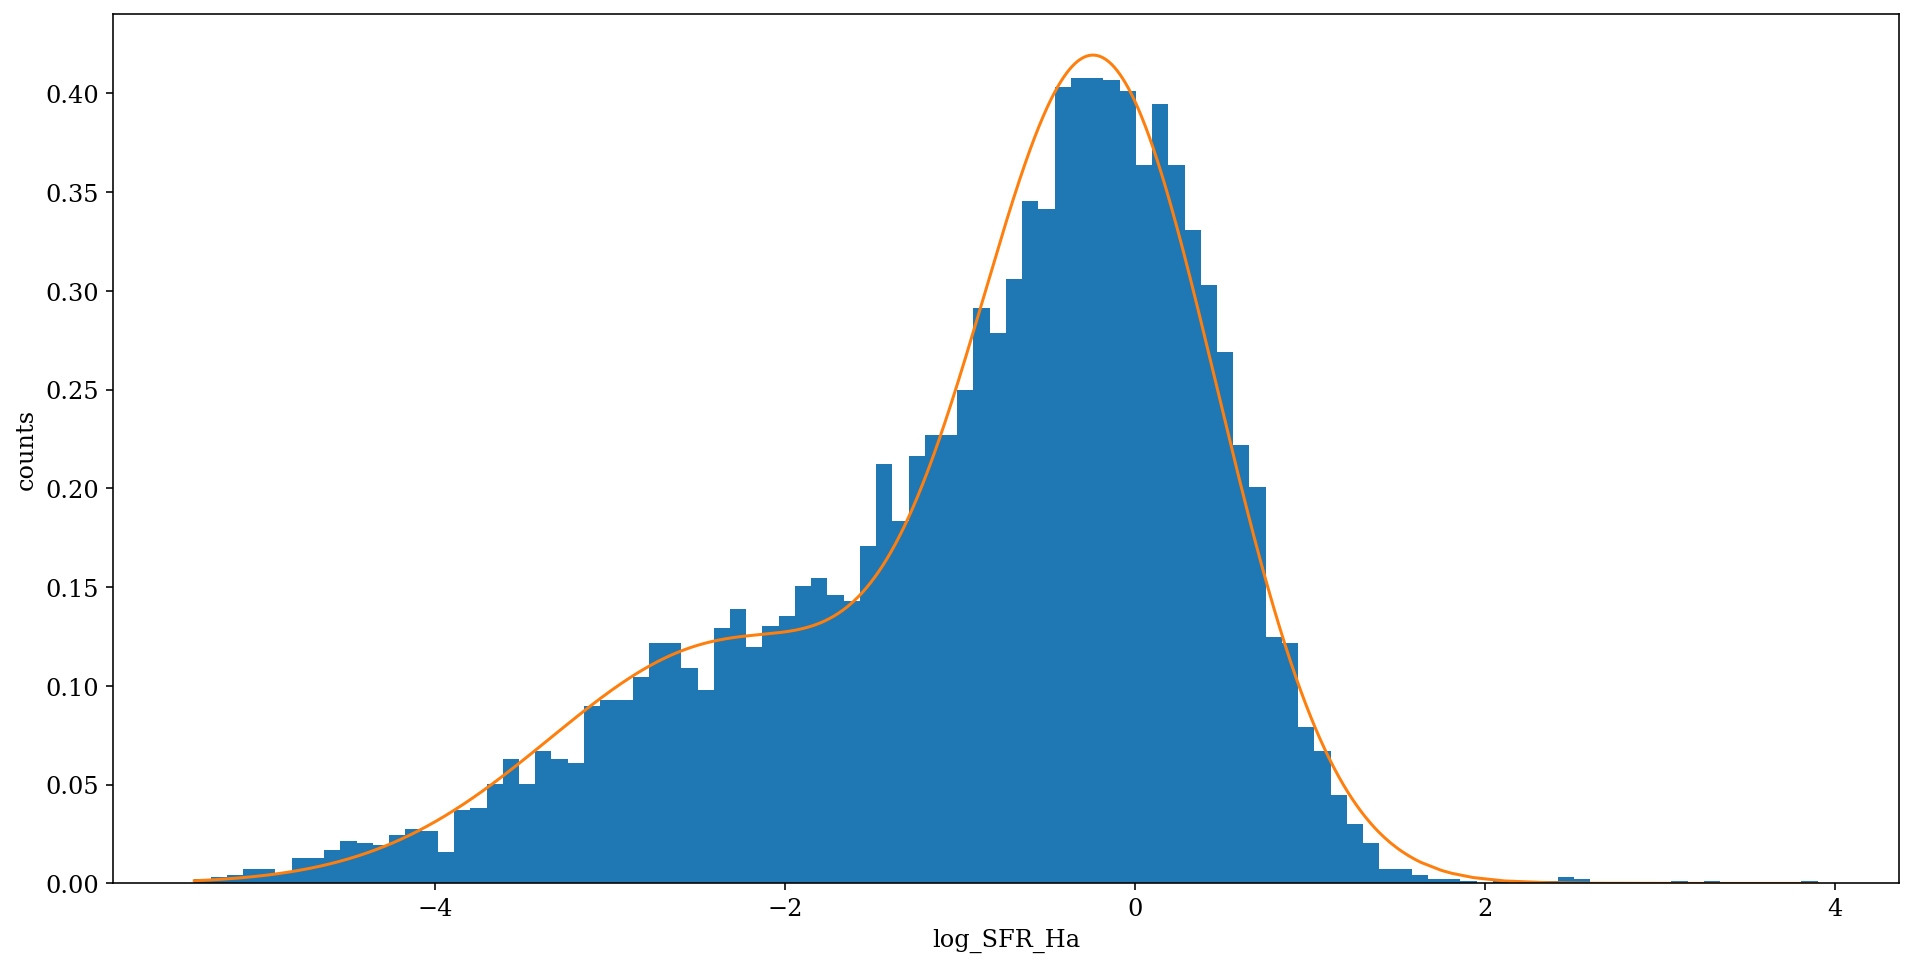

In [83]:
#histo SFR mpajhu 
key = 'log_SFR_Ha'
sfr_manga = data[manga].field(key)[data[manga].field(key) > -9.99e3]
sfr_manga = sfr_manga[:, np.newaxis]

gm = mixture.GaussianMixture(n_components = 2, tol = 1e-3, n_init = 1)
gm_fitted = gm.fit(sfr_manga)
sfr_sorted = np.sort(sfr_manga, axis = 0)

plt.hist(sfr_manga[:,0], bins = 100, density = True)
plt.plot(sfr_sorted[:,0], np.exp(gm_fitted.score_samples(sfr_sorted)))
plt.xlabel(key)
plt.ylabel('counts')

plt.show()

In [84]:
print('the means are: ')
print(gm_fitted.means_)

print('\nthe covariances are: ')
print(gm_fitted.covariances_)

the means are: 
[[-0.20670372]
 [-2.32945717]]

the covariances are: 
[[[0.46463963]]

 [[1.03104079]]]


In [97]:
key = 'log_Mass_gas_Av_gas_OH'
mask = (data[manga].field(key) > -9.99e3) & (data[manga].field('Re_kpc') > -9.99e3) & (data[manga].field('log_SFR_Ha') > -9.99e3)
gas_mass = data[manga].field(key)[mask]
R_e = data[manga].field('Re_kpc')[mask]
sfr = data[manga].field('log_SFR_Ha')[mask]

surface_density = gas_mass / R_e**2
sfr_density = sfr / R_e**2

In [130]:
p0 = [1, 1]
best_p, cov = curve_fit(kennicutt, surface_density, sfr_density, p0 = p0)

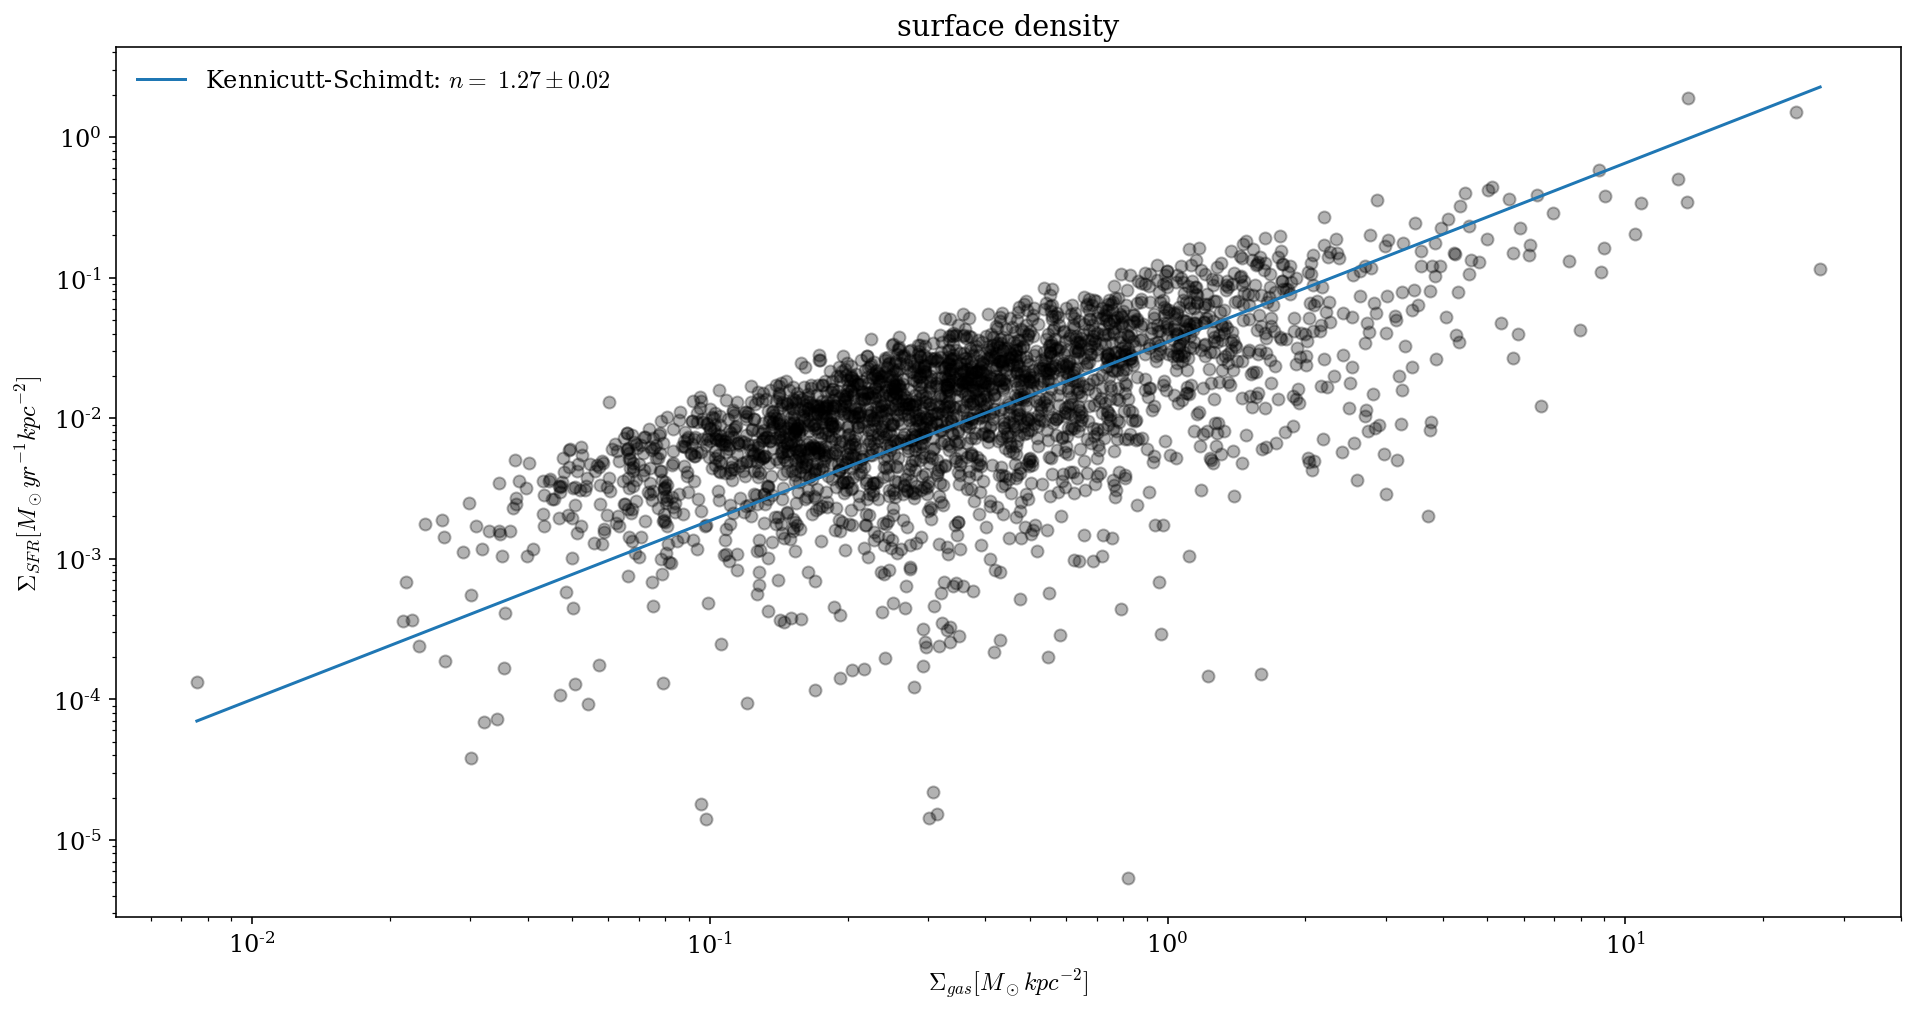

In [140]:
grid = np.linspace(surface_density.min(), surface_density.max(), 1000)

plt.scatter(surface_density, sfr_density, c='k', alpha = 0.3)
plt.plot(grid, kennicutt(grid, *np.abs(best_p)), label = 'Kennicutt-Schimdt: $n = $ $%.2f \pm %.2f $' % (best_p[1], np.sqrt(cov[1,1])))
plt.ylabel(r'$\Sigma_{SFR}[M_\odot yr^{-1} kpc^{-2}]$')
plt.xlabel(r'$\Sigma_{gas}[M_\odot kpc^{-2}]$')
plt.loglog()
plt.title('surface density')
plt.legend(frameon = False)
plt.show()

**Kennicutt-Schimdt relation**